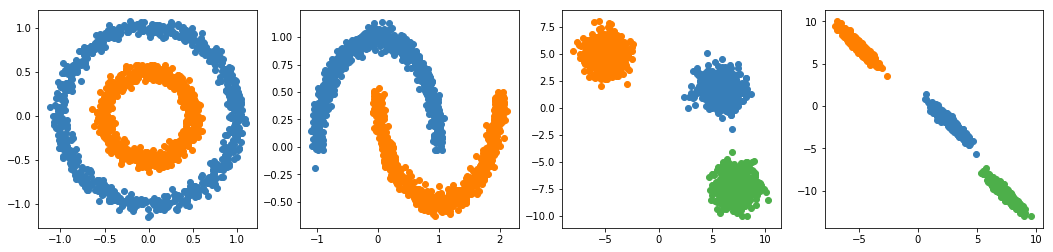

In [16]:
#Import dataset and show them
import data_prepare as dp
import utilities as utils
data_set_list=dp.get_data()
[noisy_circles, noisy_moons, blobs, aniso]=data_set_list
dp.show_four_dataset(data_set_list)

[[-2000     0    -2 ...     0    -2     0]
 [    0 -2000     0 ...     0     0     0]
 [   -2     0 -2000 ...    -2     0    -1]
 ...
 [    0     0    -2 ... -2000    -2     0]
 [   -2     0     0 ...    -2 -2000     0]
 [    0     0    -1 ...     0     0 -2000]]
0
1
2
117566.18624000077
118016.17408000147
117979.65568000151
117550.76736000086
117701.71008000041
118035.65056000155
117631.10784000072
117510.59712000107
117495.17824000103
118016.17408000147
118051.06944000143
118024.28928000132
117970.72896000132
117576.33024000094
117560.50560000073
118086.77632000131
117514.24896000091
117463.12320000106
117965.45408000129
117530.07360000089
117541.43488000089
118029.15840000135
118070.14016000138
117603.51616000074
117466.36928000103
118017.79712000143
118006.43584000134
117590.1260800006
117577.14176000074
117989.79968000119
118034.43328000154
117939.89120000126
118037.2736000014
118036.86784000143
117614.87744000061
117949.62944000143
117469.20960000125
117554.8249600008
117588.0972

TypeError: list indices must be integers, not tuple

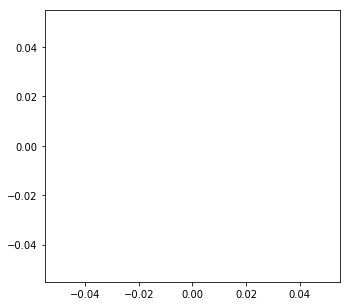

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
#Affinity Propagation Class
class AffinityCluster:
    def __init__(self,max_iterations=50,lamb=0.6,max_diff=0.00001,initial_s=-1):
        self.clusters_num=None
        self.max_iterations=max_iterations
        self.lamb=lamb
        self.max_diff=max_diff
        self.centroids=[]
        self.x_clusters=[]
        self.initial_s=initial_s
        self.lamb=lamb       
        
    def fit(self,data):
        data=np.array(data)
        max_iterations=self.max_iterations
        lamb=self.lamb
        initial_s=self.initial_s
        row_num=data.shape[0]
        
        s=self.generate_s_matrix(data,initial_s)
        print s
        a=self.generate_initial_a(row_num)
        r=self.generate_initial_r(row_num)
        
        for iter in range(max_iterations):
                print iter
                r=self.update_r(s,a,r,lamb)
                a=self.update_a(s,a,r,lamb)
        
        #Choose exemplars:
        exemplars=[]
        centroids=[]
        a_r=a+r
        for i in range(row_num):
            print a_r[i,i]
            if a_r[i,i]>0:
                exemplars.append(i)
                centroids.append(data[i])
        
        #Choose exemplar for every point
        x_clusters=[-1]*row_num
        for i in range(row_num):
            exem=-1
            exem_grade=-np.inf
            for j in exemplars:
                if a_r[i,j]>exem_grade:
                    exem=j
                    exem_grade=a_r[i,j]
            x_clusters[i]=exem
        
        self.centroids=centroids
        self.x_clusters=x_clusters
        print 
        return x_clusters            
        
    def generate_s_matrix(self,data, initial_s=-1):
        '''
        data:array[][]
        intial_s:array[] or a number
        return:array[][]
        '''
        #Check the type of input data
        if not isinstance(data,np.ndarray):
            raise TypeError('data should be a array, however a ' + str(type(data))+ 'is given')
        if len(data.shape)!=2:
            raise TypeError('data should be a 2-dimentional array')            
        if not isinstance(initial_s,(int,float,np.ndarray)):
            raise TypeError('initial_s should be a number or a array, however a ' + str(type(initial_s))+ 'is given')
        #Get info variables
        row_num=data.shape[0]
        col_num=data.shape[1]
        if not isinstance(initial_s,np.ndarray):
            initial_s=np.array([initial_s]*row_num)
        s=np.diag(initial_s)
        for i in range(row_num):
            for j in range(i+1,row_num):
                s[i,j]=-self.e_d(data[i],data[j])
                s[j,i]=s[i,j]        
        return s
    
    def generate_initial_a(self,row_num):
        '''
        raw_num: int
        return: array[][]
        '''
        return np.zeros([row_num]*2)
    
    def generate_initial_r(self,row_num):
        '''
        raw_num: int
        return: array[][]
        '''
        return np.zeros([row_num]*2)
    
    def update_r(self,s,a,r,lamb=0):
        '''
        s:array[][]
        a:array[][]
        r:array[][]
        return: array[][]
        '''
        row_num=s.shape[0]
        s_a=s+a
        for i in range(row_num):
            s_a[i,i]=-np.inf
            
        s_a_max=np.max(s_a,axis=0)
        for i in range(row_num):
            r[i]=lamb*r[i]+(1-lamb)*(s[i]-s_a_max[i])
        return r
    
    def update_a(self,s,a,r,lamb=0):
        '''
        s:array[][]
        a:array[][]
        r:array[][]
        return: array[][]
        '''
        row_num=s.shape[0]
        r_above_0=r.copy()
        r_above_0[r<0]=0
        for i in range(row_num):
            if r[i,i]<0:
                r_above_0[i,i]=r[i,i]
        r_sum=np.sum(r_above_0,axis=0)
        for i in range(row_num):
            for j in range(row_num):
                if r[i,j]>0:
                    a[i,j]=lamb*a[i,j]+(1-lamb)*np.min([0,r_sum[j]-r[i,j]])
                else:
                    a[i,j]=lamb*a[i,j]+(1-lamb)*np.min([0,r_sum[j]])
        for i in range(row_num):
            r_sum=0
            for j in range(row_num):
                if j!=i and r[j,i]>0:
                    r_sum+=r[j,i]
            a[i,i]=lamb*a[i,i]+(1-lamb)*r_sum
        return a 
            
    def e_d(self,x,y):
        d=0
        for i,j in zip(x,y):
            d+=(i-j+0.0)**2
        return d       
    

    #Apply affinity propogation
if __name__=='__main__':
    ac_cluster=AffinityCluster(max_iterations=3,initial_s=-2000)
    data_set=[noisy_circles[0]]
    utils.displot_imgs(ac_cluster,data_set)

In [50]:
reload(utils)

<module 'utilities' from 'utilities.py'>

(array([[ 0.0235485 ,  1.00290657],
       [ 0.36674663,  0.33884011],
       [ 0.01619502, -0.54051164],
       ...,
       [ 0.51205932,  0.92859179],
       [-0.23761971, -0.39955042],
       [-0.02896603,  0.5200171 ]]), array([0, 1, 1, ..., 0, 1, 1]))
